# Assemble Model using DenseNet, EfficientNet, ResNet50, XGBoost, Light GBM, and CatBoost

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import h5py
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from torchvision import transforms, models
from torchvision.models import densenet121, DenseNet121_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
# from dataset import HDF5Dataset
from sklearn.metrics import roc_auc_score, roc_curve
from isic_metric import score

## Data Loading

In [2]:
images = []
labels = []

### First, load the malignant data from original database

In [3]:
original_train_hdf5_path = 'train-image.hdf5'
original_train_metadata_path = 'train-metadata.csv'
original_train_metadata = pd.read_csv(original_train_metadata_path,low_memory=False)   
original_train_hdf5 = h5py.File(original_train_hdf5_path, 'r')

In [4]:
for i in tqdm(range(len(original_train_metadata))):
    if original_train_metadata.iloc[i]['target'] == 0: # skip non-malignant images
        continue
    image_id = original_train_metadata.iloc[i]['isic_id']
    image = original_train_hdf5[image_id][()]
    image = np.frombuffer(image, dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (128, 128))
    image = image / 255
    
    images.append(image)
    labels.append(1)
    
# original_train_hdf5.close()

100%|██████████| 401059/401059 [00:20<00:00, 19463.27it/s]


### Second, load the augmented malignant images

In [5]:
augmented_malignant_hdf5_path = 'augmented_data.hdf5'
augmented_malignant_metadata_path = 'augmented_metadata.csv'
augmented_malignant_metadata = pd.read_csv(augmented_malignant_metadata_path,low_memory=False)
augmented_malignant_hdf5 = h5py.File(augmented_malignant_hdf5_path, 'r')
n_augmentations = 5

In [6]:
for i in tqdm(range(len(augmented_malignant_metadata))):

    for j in range(n_augmentations):
        image_id = f"{augmented_malignant_metadata.iloc[i]['isic_id']}_aug{j}"
        image = augmented_malignant_hdf5[image_id][()]
        image = np.frombuffer(image, dtype=np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        # show image
        # plt.imshow(image)
        # plt.axis('off')
        # plt.show()
        image = cv2.resize(image, (128, 128))
        image = image / 255
    
        images.append(image)
        labels.append(1)
    
augmented_malignant_hdf5.close()

100%|██████████| 1965/1965 [00:09<00:00, 216.93it/s]


### Third, load the ISIC full database's malignant examples

In [7]:
isic_metadata_path = 'isic_metadata.csv'
isic_hdf5_path = 'isic_image.hdf5'
isic_metadata = pd.read_csv(isic_metadata_path,low_memory=False)
isic_hdf5 = h5py.File(isic_hdf5_path, 'r')

In [8]:
malignant_count = 0
for i in tqdm(range(len(isic_metadata))):
    if isic_metadata.iloc[i]['benign_malignant'] == 'malignant': # skip non-malignant images
        image_id = isic_metadata.iloc[i]['isic_id']
        image = isic_hdf5[image_id][()]
        image = np.frombuffer(image, dtype=np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (128, 128))
        image = image / 255
        malignant_count += 1
        
        images.append(image)
        labels.append(1)
print(f"malignant count: {malignant_count}")
isic_hdf5.close()

100%|██████████| 81722/81722 [00:19<00:00, 4165.71it/s] 

malignant count: 9239


In [9]:
malignant_count = len(labels)
print(f"malignant count: {malignant_count}")

malignant count: 19457


### Lastly, load the same amount of beign data from original database

In [10]:
idx = 0
benign_loaded = 0

pbar = tqdm(total=malignant_count, desc="Loading benign images")
while benign_loaded < malignant_count:
    if original_train_metadata.iloc[idx]['target'] == 0:
        image_id = original_train_metadata.iloc[idx]['isic_id']
        image = original_train_hdf5[image_id][()]
        image = np.frombuffer(image, dtype=np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (128, 128))
        image = image / 255
        images.append(image)
        labels.append(0)
        benign_loaded += 1
        pbar.update(1)
    idx += 1
pbar.close()

original_train_hdf5.close()
print(f"benign count: {benign_loaded}")

Loading benign images: 100%|██████████| 19457/19457 [00:14<00:00, 1323.28it/s]


benign count: 19457


In [11]:
print(len(images))

38914


### Generate Dataset

In [12]:
from dataset import HDF5Dataset
from sklearn.model_selection import train_test_split

# 70% for training
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, stratify=labels, random_state=42
)

# 15% validation, 15% testing
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [13]:
print(f'Training data: {len(X_train)}')
print(f'Validation data: {len(X_val)}')
print(f'Test data: {len(X_test)}')

Training data: 27239
Validation data: 5837
Test data: 5838


## Load CNN models

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### DenseNet

In [21]:
from torchvision.models import densenet121, DenseNet121_Weights
from ModelTrainer import Trainer
densenet_weights = DenseNet121_Weights.DEFAULT
densenet_transform = densenet_weights.transforms()
densenet_train_dataset = HDF5Dataset(X_train, y_train, augment=True, transform=densenet_transform)
densenet_val_dataset = HDF5Dataset(X_val, y_val, augment=False, transform=densenet_transform)
densenet_model = densenet121(weights=densenet_weights)
lr = 1e-4
num_epochs = 20

Epoch 1/20: 100%|██████████| 213/213 [01:28<00:00,  2.39it/s]


Epoch 1: Acc = 0.9872, Precision = 0.9907, Recall = 0.9836, F1 = 0.9871, pAUC = 0.1986


Epoch 2/20: 100%|██████████| 213/213 [01:28<00:00,  2.40it/s]


Epoch 2: Acc = 0.9901, Precision = 0.9958, Recall = 0.9842, F1 = 0.9900, pAUC = 0.1984


Epoch 3/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 3: Acc = 0.9758, Precision = 0.9627, Recall = 0.9901, F1 = 0.9762, pAUC = 0.1980


Epoch 4/20: 100%|██████████| 213/213 [01:29<00:00,  2.38it/s]


Epoch 4: Acc = 0.9904, Precision = 0.9938, Recall = 0.9870, F1 = 0.9904, pAUC = 0.1984


Epoch 5/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 5: Acc = 0.9909, Precision = 0.9962, Recall = 0.9856, F1 = 0.9909, pAUC = 0.1985


Epoch 6/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 6: Acc = 0.9885, Precision = 0.9857, Recall = 0.9914, F1 = 0.9886, pAUC = 0.1990


Epoch 7/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 7: Acc = 0.9918, Precision = 0.9979, Recall = 0.9856, F1 = 0.9917, pAUC = 0.1982


Epoch 8/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 8: Acc = 0.9914, Precision = 0.9959, Recall = 0.9870, F1 = 0.9914, pAUC = 0.1983


Epoch 9/20: 100%|██████████| 213/213 [01:28<00:00,  2.39it/s]


Epoch 9: Acc = 0.9868, Precision = 0.9958, Recall = 0.9777, F1 = 0.9867, pAUC = 0.1979


Epoch 10/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 10: Acc = 0.9870, Precision = 0.9847, Recall = 0.9894, F1 = 0.9870, pAUC = 0.1980


Epoch 11/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 11: Acc = 0.9878, Precision = 0.9938, Recall = 0.9818, F1 = 0.9878, pAUC = 0.1978


Epoch 12/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 12: Acc = 0.9913, Precision = 0.9945, Recall = 0.9880, F1 = 0.9912, pAUC = 0.1984


Epoch 13/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 13: Acc = 0.9895, Precision = 0.9904, Recall = 0.9887, F1 = 0.9895, pAUC = 0.1984


Epoch 14/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 14: Acc = 0.9911, Precision = 0.9948, Recall = 0.9873, F1 = 0.9911, pAUC = 0.1979


Epoch 15/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 15: Acc = 0.9919, Precision = 0.9959, Recall = 0.9880, F1 = 0.9919, pAUC = 0.1981


Epoch 16/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 16: Acc = 0.9897, Precision = 0.9955, Recall = 0.9839, F1 = 0.9897, pAUC = 0.1968


Epoch 17/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 17: Acc = 0.9909, Precision = 0.9952, Recall = 0.9866, F1 = 0.9909, pAUC = 0.1980


Epoch 18/20: 100%|██████████| 213/213 [01:28<00:00,  2.39it/s]


Epoch 18: Acc = 0.9884, Precision = 0.9873, Recall = 0.9894, F1 = 0.9884, pAUC = 0.1982


Epoch 19/20: 100%|██████████| 213/213 [01:28<00:00,  2.39it/s]


Epoch 19: Acc = 0.9906, Precision = 0.9958, Recall = 0.9853, F1 = 0.9905, pAUC = 0.1983


Epoch 20/20: 100%|██████████| 213/213 [01:29<00:00,  2.39it/s]


Epoch 20: Acc = 0.9911, Precision = 0.9931, Recall = 0.9890, F1 = 0.9911, pAUC = 0.1980


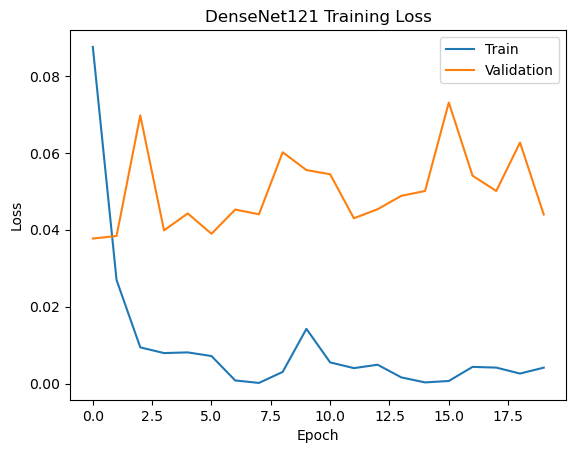

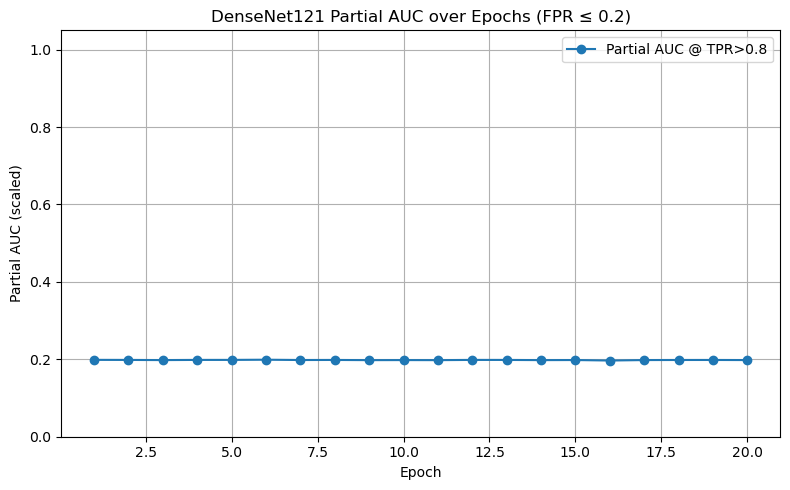

In [22]:
dense_net_trainer = Trainer(device, densenet_train_dataset, densenet_val_dataset, "DenseNet121", densenet_weights, densenet_transform, densenet_model, lr, num_epochs)
dense_net_trainer.train()

#### Convert DenseNet's output predictions

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch.nn.functional as F
from PIL import Image

class TorchCNNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, device='cpu', transform=None, threshold=0.5):
        self.model = model.eval().to(device)
        self.device = device
        self.transform = transform
        self.threshold = threshold

    def _prepare_image(self, img):
        if isinstance(img, np.ndarray):
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)
            img = Image.fromarray(img)
        return self.transform(img).unsqueeze(0).to(self.device)  # Add batch dim

    def predict_proba(self, X):
        self.model.eval()
        probs = []
    
        with torch.no_grad():
            for img in tqdm(X, desc="Predicting with CNN"):
                img_tensor = self._prepare_image(img)
                logits = self.model(img_tensor)
                prob = torch.sigmoid(logits).cpu().item()
                probs.append([1 - prob, prob])
    
        return np.array(probs)

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs[:, 1] >= self.threshold).astype(int)

In [21]:
densenet_model.eval()
densenet_wrapper = TorchCNNWrapper(
    model=densenet_model,
    device=device,
    transform=densenet_transform
)

In [22]:
densenet_wrapper_probas = densenet_wrapper.predict_proba(X_train)[:, 1]

Predicting with CNN: 100%|██████████| 31131/31131 [08:20<00:00, 62.23it/s]


In [23]:
densenet_wrapper_probas[:10]

array([1.45523998e-07, 8.57164632e-05, 9.99995470e-01, 1.77413749e-05,
       1.86663427e-04, 9.99997139e-01, 4.80225566e-08, 1.41859646e-05,
       4.25798025e-05, 9.99991298e-01])

## EfficientNet

In [23]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
efficientnet_weights = EfficientNet_B3_Weights.DEFAULT
efficientnet_transform = efficientnet_weights.transforms()
efficientnet_train_dataset = HDF5Dataset(X_train, y_train, augment=True, transform=efficientnet_transform)
efficientnet_val_dataset = HDF5Dataset(X_val, y_val, augment=False, transform=efficientnet_transform)
efficientnet_model = efficientnet_b3(weights=efficientnet_weights)
lr = 1e-4
num_epochs = 20

EfficientNet Configuration


Epoch 1/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 1: Acc = 0.9909, Precision = 0.9997, Recall = 0.9822, F1 = 0.9908, pAUC = 0.1988


Epoch 2/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 2: Acc = 0.9919, Precision = 0.9962, Recall = 0.9877, F1 = 0.9919, pAUC = 0.1987


Epoch 3/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 3: Acc = 0.9921, Precision = 0.9983, Recall = 0.9859, F1 = 0.9921, pAUC = 0.1987


Epoch 4/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 4: Acc = 0.9892, Precision = 0.9890, Recall = 0.9894, F1 = 0.9892, pAUC = 0.1983


Epoch 5/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 5: Acc = 0.9906, Precision = 0.9938, Recall = 0.9873, F1 = 0.9905, pAUC = 0.1984


Epoch 6/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 6: Acc = 0.9916, Precision = 0.9945, Recall = 0.9887, F1 = 0.9916, pAUC = 0.1983


Epoch 7/20: 100%|██████████| 213/213 [02:58<00:00,  1.20it/s]


Epoch 7: Acc = 0.9918, Precision = 0.9948, Recall = 0.9887, F1 = 0.9917, pAUC = 0.1982


Epoch 8/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 8: Acc = 0.9911, Precision = 0.9935, Recall = 0.9887, F1 = 0.9911, pAUC = 0.1983


Epoch 9/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 9: Acc = 0.9921, Precision = 0.9965, Recall = 0.9877, F1 = 0.9921, pAUC = 0.1980


Epoch 10/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 10: Acc = 0.9916, Precision = 0.9948, Recall = 0.9883, F1 = 0.9916, pAUC = 0.1981


Epoch 11/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 11: Acc = 0.9926, Precision = 0.9955, Recall = 0.9897, F1 = 0.9926, pAUC = 0.1983


Epoch 12/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 12: Acc = 0.9916, Precision = 0.9983, Recall = 0.9849, F1 = 0.9915, pAUC = 0.1985


Epoch 13/20: 100%|██████████| 213/213 [02:59<00:00,  1.19it/s]


Epoch 13: Acc = 0.9909, Precision = 0.9924, Recall = 0.9894, F1 = 0.9909, pAUC = 0.1985


Epoch 14/20: 100%|██████████| 213/213 [02:59<00:00,  1.19it/s]


Epoch 14: Acc = 0.9909, Precision = 0.9938, Recall = 0.9880, F1 = 0.9909, pAUC = 0.1984


Epoch 15/20: 100%|██████████| 213/213 [02:59<00:00,  1.19it/s]


Epoch 15: Acc = 0.9914, Precision = 0.9965, Recall = 0.9863, F1 = 0.9914, pAUC = 0.1984


Epoch 16/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 16: Acc = 0.9911, Precision = 0.9965, Recall = 0.9856, F1 = 0.9910, pAUC = 0.1980


Epoch 17/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 17: Acc = 0.9913, Precision = 0.9935, Recall = 0.9890, F1 = 0.9912, pAUC = 0.1983


Epoch 18/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 18: Acc = 0.9911, Precision = 0.9931, Recall = 0.9890, F1 = 0.9911, pAUC = 0.1989


Epoch 19/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 19: Acc = 0.9913, Precision = 0.9945, Recall = 0.9880, F1 = 0.9912, pAUC = 0.1987


Epoch 20/20: 100%|██████████| 213/213 [02:58<00:00,  1.19it/s]


Epoch 20: Acc = 0.9919, Precision = 0.9969, Recall = 0.9870, F1 = 0.9919, pAUC = 0.1982


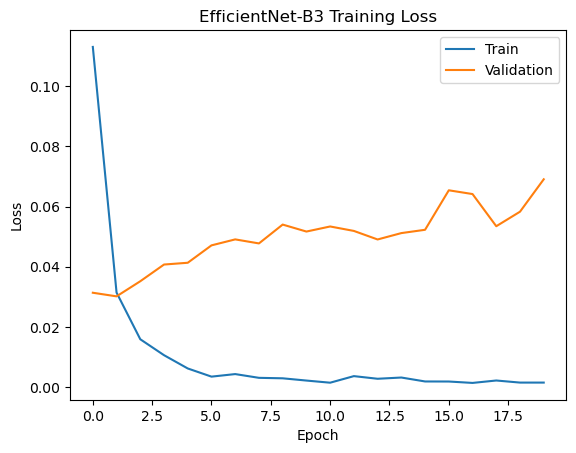

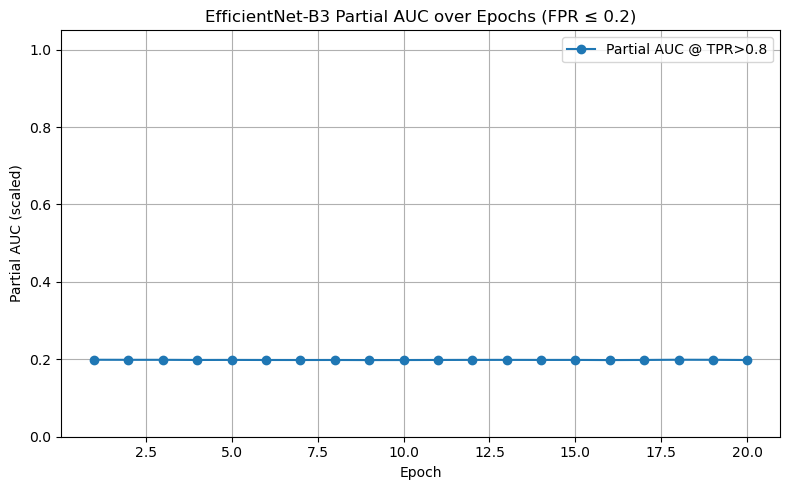

In [24]:
efficientnet_trainer = Trainer(device, efficientnet_train_dataset, efficientnet_val_dataset, "EfficientNet-B3", efficientnet_weights, efficientnet_transform, efficientnet_model, lr, num_epochs)
efficientnet_trainer.train()